In [1]:
import _mypackage

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [2]:
import my_plotting as mp

In [3]:
import sys
sys.path.append('./SAMBA')

In [4]:
from SAMBA.samba import models
from SAMBA.samba import mixing
from Taweret.mix.linear import LinearMixerLocal
from Taweret.core.base_model import BaseModel
from bilby.core import prior as bilby_prior

In [16]:
from scipy.stats import gamma

Samba GitHub repository available at: https://github.com/asemposki/SAMBA  
I presonally clone it into the same directory as this notebook.

In [5]:
class loworder(BaseModel):
    """
    A wrapper for SAMBA low order expansion function

    """

    def __init__(self, order, error_model='informative'):
        """
        Parameters
        ----------
        order : int
            Truncation order of expansion
        error_model : str
            Error calculation method. Either 'informative' or 'uninformative'
        
        Raises
        ------
        TypeError
            If the order is not an integer
        """

        if isinstance(order, int):
            self.order = order
        else:
            raise TypeError(f"order has to be an integer number: {order}")

        self.error_model = error_model
        self.m_prior = None

    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        
        Returns:
        --------
        mean : numpy 1darray
            The mean of the model
        np.sqrt(var) : numpy 1darray
            The truncation error of the model
        """

        order = self.order
        M = models.Models(order, order)
        mean = M.low_g(input_values)
        U = models.Uncertainties(self.error_model)
        var = U.variance_low(input_values, order)

        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        predictions, model_err = self.evaluate(x_exp)
        sigma = np.sqrt(np.square(y_err) + np.square(model_err))
        diff = -0.5* np.square((predictions.flatten() - y_exp)/ sigma) \
            - 0.5 * np.log(2*np.pi)- np.log(sigma)
        return diff

    def set_prior(self):
        '''
        Set the prior on model parameters.
        Not needed for this model. 
        '''
        return None


class highorder(BaseModel):
    """
    A wrapper for SAMBA high order expansion function

    """   

    def __init__(self, order, error_model='informative'):
        """
        Parameters
        ----------
        order : int
            Truncation order of expansion
        error_model : str
            Error calculation method. Either 'informative' or 'uninformative'
        
        Raises
        ------
        TypeError
            If the order is not an integer
        """

        if isinstance(order, int):
            self.order = order
        else:
            raise TypeError(f"order has to be an integer number: {order}")

        self.error_model = error_model
        self.m_prior = None
        
    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values

        Returns:
        --------
        mean : numpy 1darray
            The mean of the model
        np.sqrt(var) : numpy 1darray
            The truncation error of the model
        """

        order = self.order
        M = models.Models(order, order)
        mean = M.high_g(input_values)
        U = models.Uncertainties(self.error_model)
        var = U.variance_high(input_values, order)

        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        predictions, model_err = self.evaluate(x_exp)
        sigma = np.sqrt(np.square(y_err) + np.square(model_err))
        diff = -0.5* np.square((predictions.flatten() - y_exp)/ sigma) \
            - 0.5 * np.log(2*np.pi)- np.log(sigma)
        return diff

    def set_prior(self):
        '''
        Set the prior on the model parameters.
        Not needed for this model. 
        '''
        return None
    

class true_model(BaseModel):
    """
    A wrapper for SAMBA  true function
    """

    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values
        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        """

        order = 1
        M = models.Models(order, order)
        mean = M.true_model(input_values)
        var = np.zeros(shape=mean.shape)
        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        return log_likelihood_elementwise_utils(self, x_exp, y_exp, y_err)

    def set_prior(self):
        '''
        Set the prior on any model parameters.
        Not needed for this model. 
        '''
        return None 


class exp_data(BaseModel):    # --> check that this model is set up correctly
    """
    A wrapper for SAMBA data function

    """

    def evaluate(self, input_values : np.array, error = 0.01) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        error : float
            defines the relative error as a fraction between (0,1)
        """

        order = 1
        M = mixing.LMM(order, order, error_model='informative')
        mean, sigma = M.add_data(input_values, input_values, error=error, plot=False)
        
        return mean, sigma

    def log_likelihood_elementwise(self):
        return None

    def set_prior(self):
        '''
        Set the prior on any model parameters.
        Not needed for this model. 
        '''
        return None 

In [6]:
m1 = loworder(2, 'uninformative')
m2 = highorder(2, 'uninformative')
truth = true_model()
exp = exp_data()

In [7]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g, error = 0.01)

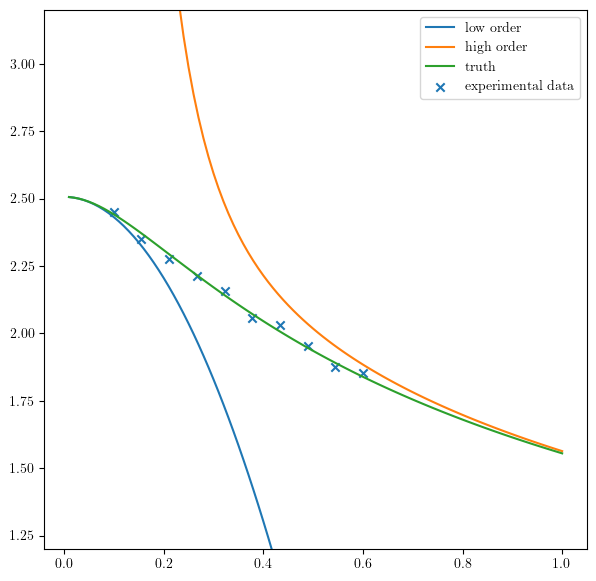

In [8]:
fig, ax_f = plt.subplots(figsize=(7, 7))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g, exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

## With Deterministic Priors

In [9]:
my_models = {'low_order':m1,'high_order':m2}
mix_model = LinearMixerLocal(models=my_models) 
mix_model.set_prior(
    example_local_variable=np.array([0]),
    local_variables_ranges=np.array([[-20, 20]]),
    deterministic_priors=True,
    polynomial_order=1
)

In [10]:
exp_data

(array([2.42629793, 2.34251373, 2.31875147, 2.20558066, 2.1343379 ,
        2.08210412, 1.99436289, 1.96495989, 1.89644489, 1.86425679]),
 array([0.02426298, 0.02342514, 0.02318751, 0.02205581, 0.02134338,
        0.02082104, 0.01994363, 0.0196496 , 0.01896445, 0.01864257]))

In [11]:
posterior = mix_model.train(
    y_exp=exp_data[0],
    y_err=exp_data[1],
    local_variables=g,
    outdir='./plots',
)

00:29 bilby INFO    : Running for label 'label', output will be saved to './plots'
00:29 bilby INFO    : Analysis priors:
00:29 bilby INFO    : slope_(1, 0)=Uniform(minimum=-20, maximum=20, name='mu_(1, 0)', latex_label='mu_(1, 0)', unit=None, boundary=None)
00:29 bilby INFO    : intercept_(1, 0)=Uniform(minimum=-20, maximum=20, name='sigma_(1, 0)', latex_label='sigma_(1, 0)', unit=None, boundary=None)
00:29 bilby INFO    : Analysis likelihood class: <class 'Taweret.mix.linear.LinearMixerLocal.MixLikelihood'>
00:29 bilby INFO    : Analysis likelihood noise evidence: nan


KeyError: 'slope_(0, 0)'

In [12]:
_, CI_prior, mean_prior, _ = mix_model.prior_predict(
    local_variables=plot_g,
    credible_interval=[5, 20, 80, 95]
)
_, CI, mean, _ = mix_model.predict(
    local_variables=plot_g,
    credible_intervals=[5, 20, 80, 95]
)

In [13]:
map_prediction = mix_model.evaluate(
    local_variables=plot_g,
    sample=dict((key, var) 
                for key, var in zip(
                    mix_model.prior.keys(),
                    mix_model.map
                )
               )
)

In [14]:
CI_prior.shape

(4, 100)

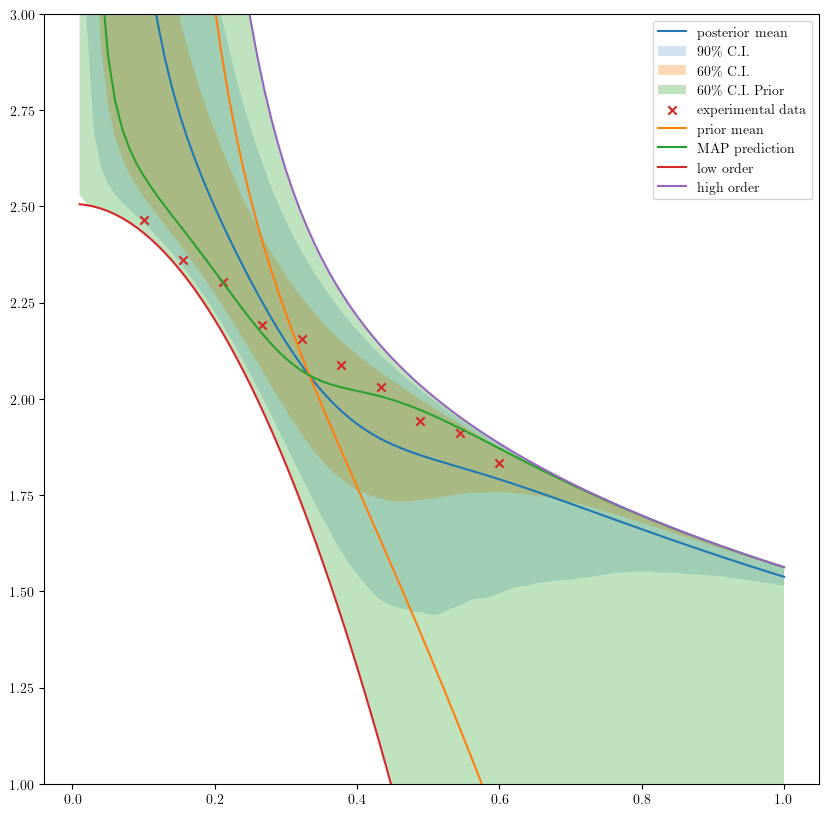

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(
    plot_g, 
    mean.flatten(),
    label='posterior mean'
)
ax.fill_between(
    plot_g,
    CI[0].flatten(),
    CI[3].flatten(),
    alpha=0.2,
    label=r'90\% C.I.'
)
ax.fill_between(
    plot_g,
    CI[1].flatten(),
    CI[2].flatten(),
    alpha=0.3,
    label=r'60\% C.I.'
)
ax.fill_between(
    plot_g,
    CI_prior[1].flatten(),
    CI_prior[2].flatten(),
    alpha=0.3,
    label='60\% C.I. Prior'
)
ax.scatter(
    g,
    exp_data[0],
    marker='x',
    label='experimental data'
)
ax.plot(
    plot_g, 
    mean_prior.flatten(),
    label='prior mean'
)
ax.plot(
    plot_g,
    map_prediction.flatten(),
    label='MAP prediction'
)
ax.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax.set_ybound(1,3)
ax.legend()

In [16]:
weights = mix_model.evaluate_weights(
    local_variables=plot_g,
    sample=dict((key, var)
                for key, var in zip(
                    mix_model.prior.keys(),
                    mix_model.map
                )
               )
)

_, CI_weights, mean_weights, _ = mix_model.predict_weights(
    local_variables=plot_g
)

In [17]:
mean_weights.shape

(100, 2)

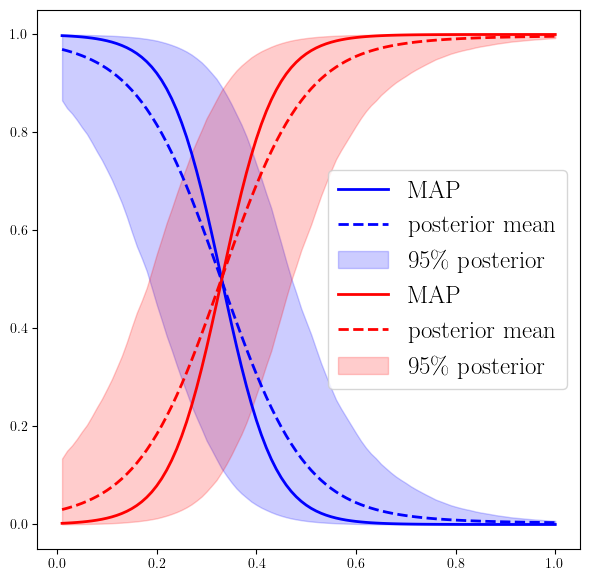

In [18]:
fig2, ax2 = plt.subplots(figsize=(7, 7))
fig2.patch.set_facecolor('white')
ax2.plot(plot_g, weights[0], color='blue', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 0], color='blue', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :,0], CI_weights[1, :,0], color='blue', alpha=0.2, label='95\% posterior')
ax2.plot(plot_g, weights[1], color='red', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 1], color='red', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :, 1], CI_weights[1, :, 1], color='red', alpha=0.2, label='95\% posterior')
ax2.legend(fontsize=18)

In [19]:
low_y = m1.evaluate(plot_g)[0]
high_y = m2.evaluate(plot_g)[0]

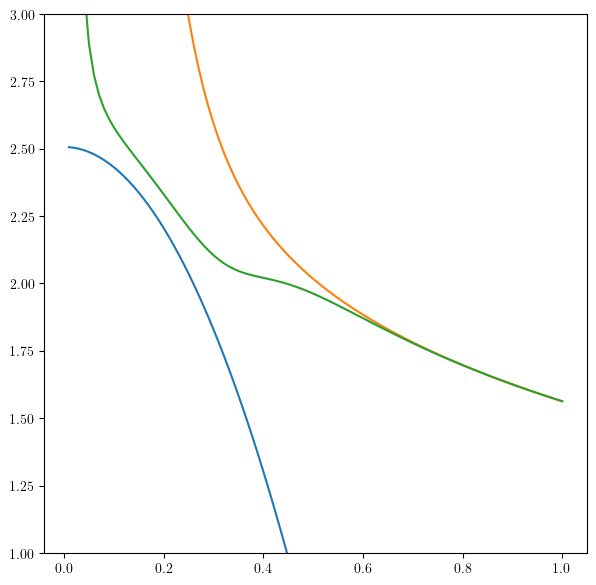

In [20]:
fig3, ax3 = plt.subplots(figsize=(7, 7))
fig3.patch.set_facecolor('white')
ax3.plot(plot_g, low_y.flatten())
ax3.plot(plot_g, high_y.flatten())
ax3.plot(
    plot_g,
    weights[0] * low_y.flatten() + weights[1] * high_y.flatten()
)
ax3.set_ybound(1,3)

In [21]:
mix_model.map

array([-18.82242694,   6.22212106])

## With Stochastic Prior

In [9]:
my_models = {'low_order':m1,'high_order':m2}
mix_model = LinearMixerLocal(models=my_models) 
mix_model.set_prior(
    example_local_variable=np.array([0]),
    local_variables_ranges=np.array([[-20, 20]]),
    deterministic_priors=False,
)

In [10]:
exp_data

(array([2.45196791, 2.35149256, 2.27762061, 2.21382012, 2.15846416,
        2.0568079 , 2.03099925, 1.95340719, 1.87662764, 1.85212154]),
 array([0.02451968, 0.02351493, 0.02277621, 0.0221382 , 0.02158464,
        0.02056808, 0.02030999, 0.01953407, 0.01876628, 0.01852122]))

22:02 bilby INFO    : Running for label 'label', output will be saved to './plots'
22:02 bilby INFO    : Analysis priors:
22:02 bilby INFO    : gp_variance=Gamma(k=5, theta=1, name=None, latex_label=None, unit=None, boundary=None)
22:02 bilby INFO    : Analysis likelihood class: <class 'Taweret.mix.linear.LinearMixerLocal.MixLikelihood'>
22:02 bilby INFO    : Analysis likelihood noise evidence: nan
22:02 bilby INFO    : Single likelihood evaluation took 6.027e-03 s
22:02 bilby WARNING : Supplied argument 'printdt' not an argument of 'Ptemcee', removing.
22:02 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 10, 'nwalkers': 40, 'Tmax': 100, 'betas': None, 'a': 2.0, 'adaptation_lag': 10000, 'adaptation_time': 100, 'random': None, 'adapt': False, 'swap_ratios': False}
22:02 bilby INFO    : Using convergence inputs: ConvergenceInputs(autocorr_c=5, autocorr_tol=50, autocorr_tau=1, gradient_tau=0.1, gradient_mean_log_posterior=0.1, Q_tol=1.02, safety=1, burn_in_nact=50, burn_in_f

True


22:02 bilby INFO    : Generating pos0 samples
22:02 bilby INFO    : Starting to sample


1|0:00:04|nc:2.0e+03|a0:0.00-1.00|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|2.37ms/ev
2|0:00:08|nc:4.0e+03|a0:0.00-0.50|swp:0.74-0.98|n:nan<4000|t!nan(+nan,+nan)|q:inf|2.24ms/ev
3|0:00:14|nc:6.0e+03|a0:0.13-0.53|swp:0.73-0.98|n:nan<4000|t!nan(+nan,+nan)|q:inf|2.37ms/ev
4|0:00:18|nc:8.0e+03|a0:0.15-0.50|swp:0.74-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|2.22ms/ev
5|0:00:21|nc:1.0e+04|a0:0.20-0.44|swp:0.74-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|2.15ms/ev
6|0:00:25|nc:1.2e+04|a0:0.17-0.43|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
7|0:00:29|nc:1.4e+04|a0:0.17-0.43|swp:0.74-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
8|0:00:33|nc:1.6e+04|a0:0.20-0.50|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
9|0:00:36|nc:1.8e+04|a0:0.18-0.44|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
10|0:00:40|nc:2.0e+04|a0:0.20-0.46|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.88ms/ev
11|0:00:44|nc:2.2e+04|a0:0.20-0.45|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:

22:12 bilby INFO    : Writing checkpoint and diagnostics
22:12 bilby INFO    : Finished writing checkpoint
22:12 bilby INFO    : Walkers plot failed with exception cannot unpack non-iterable AxesSubplot object


155|0:09:49|nc:3.1e+05|a0:0.29-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.97ms/ev
156|0:09:53|nc:3.1e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.95ms/ev
157|0:09:57|nc:3.1e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.93ms/ev
158|0:10:00|nc:3.2e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.88ms/ev
159|0:10:04|nc:3.2e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.87ms/ev
160|0:10:08|nc:3.2e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.86ms/ev
161|0:10:12|nc:3.2e+05|a0:0.28-0.34|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.86ms/ev
162|0:10:16|nc:3.2e+05|a0:0.29-0.34|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
163|0:10:19|nc:3.3e+05|a0:0.28-0.34|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
164|0:10:23|nc:3.3e+05|a0:0.29-0.34|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
165|0:10:27|nc:3.3e+05|a0:0.29-0.34|swp:0.73-0.99|n:nan<4000

22:22 bilby INFO    : Writing checkpoint and diagnostics
22:22 bilby INFO    : Finished writing checkpoint
22:22 bilby INFO    : Walkers plot failed with exception cannot unpack non-iterable AxesSubplot object


314|0:19:50|nc:6.3e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.92ms/ev
315|0:19:54|nc:6.3e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.94ms/ev
316|0:19:58|nc:6.3e+05|a0:0.28-0.34|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.94ms/ev
317|0:20:01|nc:6.3e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
318|0:20:05|nc:6.4e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
319|0:20:09|nc:6.4e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.90ms/ev
320|0:20:13|nc:6.4e+05|a0:0.28-0.33|swp:0.72-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
321|0:20:17|nc:6.4e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
322|0:20:20|nc:6.4e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.88ms/ev
323|0:20:24|nc:6.5e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
324|0:20:28|nc:6.5e+05|a0:0.28-0.33|swp:0.73-0.99|n:nan<4000

22:32 bilby INFO    : Writing checkpoint and diagnostics
22:32 bilby INFO    : Finished writing checkpoint
22:32 bilby INFO    : Walkers plot failed with exception cannot unpack non-iterable AxesSubplot object


474|0:29:52|nc:9.5e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
475|0:29:55|nc:9.5e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
476|0:29:59|nc:9.5e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.91ms/ev
477|0:30:03|nc:9.5e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.88ms/ev
478|0:30:07|nc:9.6e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
479|0:30:10|nc:9.6e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.88ms/ev
480|0:30:14|nc:9.6e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.87ms/ev
481|0:30:18|nc:9.6e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.89ms/ev
482|0:30:22|nc:9.6e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.90ms/ev
483|0:30:26|nc:9.7e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000|t!nan(+nan,+nan)|q:inf|1.90ms/ev
484|0:30:29|nc:9.7e+05|a0:0.29-0.33|swp:0.73-0.99|n:nan<4000

22:42 bilby INFO    : Finished sampling
22:42 bilby INFO    : Writing checkpoint and diagnostics
22:42 bilby INFO    : Finished writing checkpoint
22:42 bilby INFO    : Walkers plot failed with exception cannot unpack non-iterable AxesSubplot object
22:42 bilby INFO    : Sampling time: 0:39:32.342518
22:42 bilby INFO    : Summary of results:
nsamples: 4040
ln_noise_evidence:    nan
ln_evidence:  0.403 +/-  0.065
ln_bayes_factor:    nan +/-  0.065



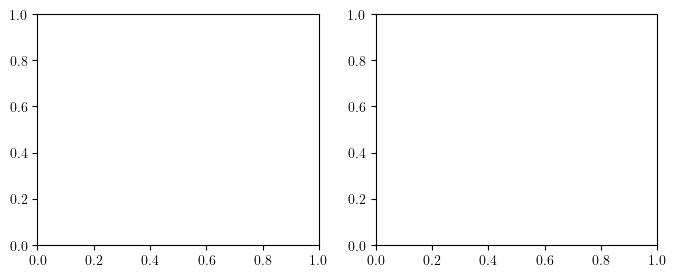

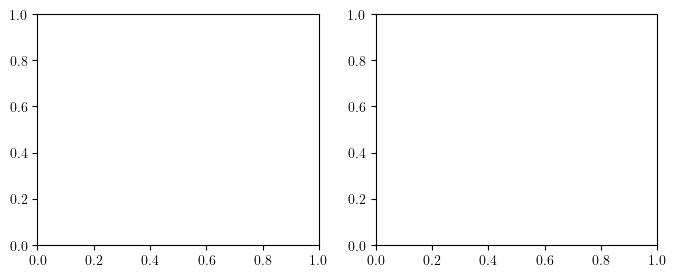

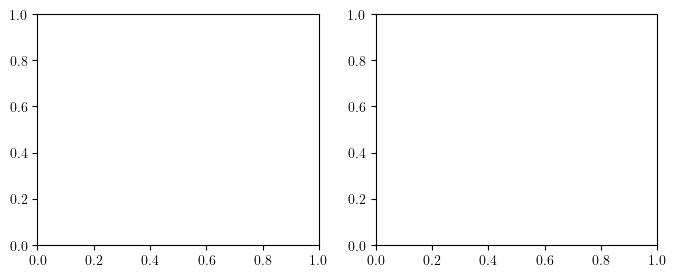

In [11]:
posterior = mix_model.train(
    y_exp=exp_data[0],
    y_err=exp_data[1],
    local_variables=g,
    outdir='./plots',
)

In [ ]:
_, CI_prior, mean_prior, _ = mix_model.prior_predict(
    local_variables=plot_g,
    credible_interval=[5, 20, 80, 95]
)
_, CI, mean, _ = mix_model.predict(
    local_variables=plot_g,
    credible_intervals=[5, 20, 80, 95]
)

In [ ]:
map_prediction = mix_model.evaluate(
    local_variables=plot_g,
    sample=dict(
        (key, var) 
        for key, var in zip(
            mix_model.prior.keys(),
            mix_model.map
        )
    )
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(
    plot_g, 
    mean.flatten(),
    label='posterior mean'
)
ax.fill_between(
    plot_g,
    CI[0].flatten(),
    CI[3].flatten(),
    alpha=0.2,
    label=r'90\% C.I.'
)
ax.fill_between(
    plot_g,
    CI[1].flatten(),
    CI[2].flatten(),
    alpha=0.3,
    label=r'60\% C.I.'
)
ax.fill_between(
    plot_g,
    CI_prior[1].flatten(),
    CI_prior[2].flatten(),
    alpha=0.3,
    label='60\% C.I. Prior'
)
ax.scatter(
    g,
    exp_data[0],
    marker='x',
    label='experimental data'
)
ax.plot(
    plot_g, 
    mean_prior.flatten(),
    label='prior mean'
)
ax.plot(
    plot_g,
    map_prediction.flatten(),
    label='MAP prediction'
)
ax.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax.set_ybound(1,3)
ax.legend()

In [ ]:
weights = mix_model.evaluate_weights(
    local_variables=plot_g,
    sample=dict((key, var)
                for key, var in zip(
                    mix_model.prior.keys(),
                    mix_model.map
                )
               )
)

_, CI_weights, mean_weights, _ = mix_model.predict_weights(
    local_variables=plot_g
)

In [17]:
mean_weights.shape

(100, 2)

NameError: name 'weights' is not defined

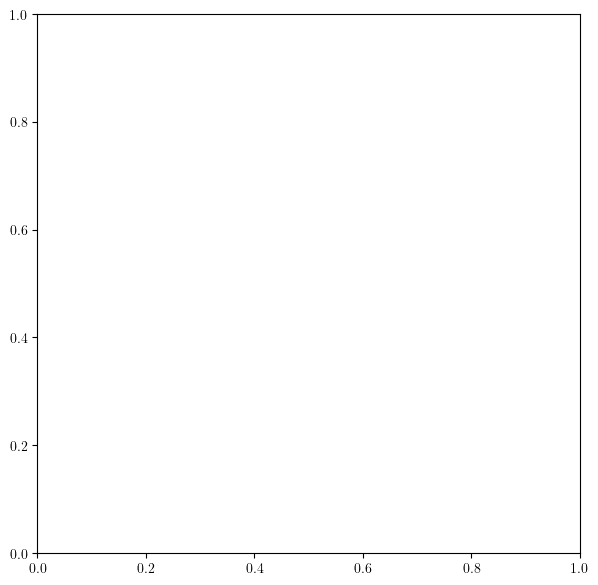

In [12]:
fig2, ax2 = plt.subplots(figsize=(7, 7))
fig2.patch.set_facecolor('white')
ax2.plot(plot_g, weights[0], color='blue', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 0], color='blue', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :,0], CI_weights[1, :,0], color='blue', alpha=0.2, label='95\% posterior')
ax2.plot(plot_g, weights[1], color='red', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 1], color='red', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :, 1], CI_weights[1, :, 1], color='red', alpha=0.2, label='95\% posterior')
ax2.legend(fontsize=18)

In [12]:
print(np.array(mix_model.sampled_weigths).shape)
mean_sampled_weights = np.mean(mix_model.sampled_weigths, axis=0)
sixty_ci_sampled_weights = np.quantile(a=mix_model.sampled_weigths, q=[0.20, 0.80], axis=0)
sixty_ci_sampled_weights.shape

(502, 2, 10)


(2, 2, 10)

<AxesSubplot: xlabel='$x$', ylabel='$w_i(x)$'>

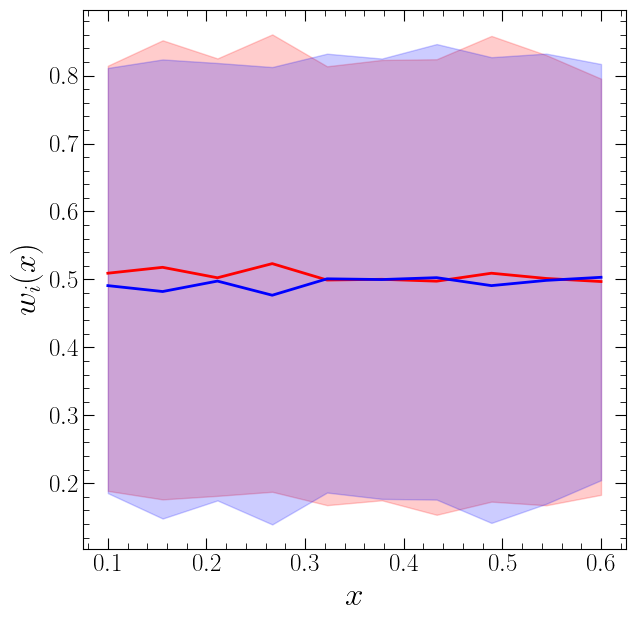

In [13]:
fig3, ax3 = plt.subplots(figsize=(7, 7))
fig3.patch.set_facecolor('white')

mean_sampled_weights = np.mean(mix_model.sampled_weigths, axis=0)
sixty_ci_sampled_weights = np.quantile(a=mix_model.sampled_weigths, q=[0.20, 0.80], axis=0)
colors = ['red', 'blue']
labels = ['model 1', 'model 2']
for i in range(2):
    ax3.plot(g, mean_sampled_weights[i], lw=2, color=colors[i], label=labels[i])
    ax3.fill_between(g, *sixty_ci_sampled_weights[:, i], color=colors[i], alpha=0.2)
mp.costumize_axis(ax3, r'$x$', r'$w_i(x)$')

(4040, 1)


(array([  1.,   1.,   3.,  10.,   9.,  18.,  28.,  37.,  53.,  54.,  72.,
         77.,  74.,  97., 102., 112., 103., 131., 108., 124., 112., 139.,
        108., 135., 136., 110., 139., 120., 123., 115., 103., 111.,  94.,
         95.,  94.,  83.,  72.,  71.,  58.,  64.,  64.,  55.,  55.,  53.,
         48.,  41.,  32.,  36.,  36.,  26.,  26.,  21.,  17.,  28.,  18.,
         19.,  13.,  13.,   9.,   4.,  15.,   8.,   4.,  12.,  10.,   2.,
          3.,   5.,   5.,   3.,   3.,   1.,   1.,   0.,   1.,   2.,   1.,
          3.,   0.,   0.,   1.,   3.,   0.,   1.,   0.,   0.,   1.,   0.,
          2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.35168012,  0.51792929,  0.68417845,  0.85042761,  1.01667678,
         1.18292594,  1.3491751 ,  1.51542427,  1.68167343,  1.84792259,
         2.01417176,  2.18042092,  2.34667008,  2.51291925,  2.67916841,
         2.84541758,  3.01166674,  3.1779159 ,  3.34416507,  3.51041423,
         3.67666339,  3.84

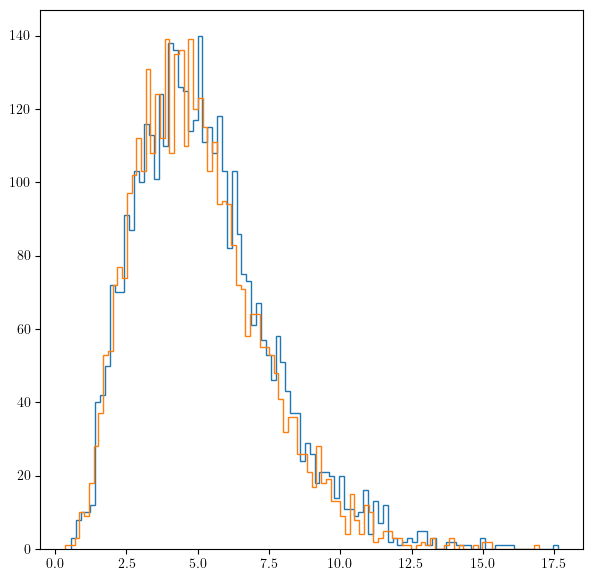

In [20]:
fig4, ax4 = plt.subplots(figsize=(7, 7))
fig4.patch.set_facecolor('white')
print(mix_model.posterior.shape)
ax4.hist(mix_model.posterior.flatten(), histtype='step', bins=100)
ax4.hist(gamma.rvs(a=5, scale=1, size=4000), histtype='step', bins=100)

## Testing some things

In [22]:
from scipy.stats import norm

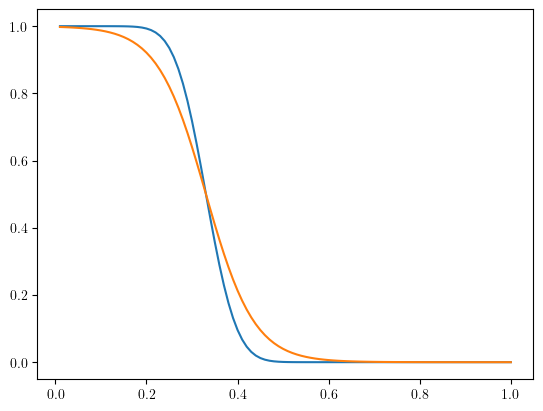

In [25]:
x = -18.82242694 * plot_g + 6.22212106
plt.plot(plot_g, norm.cdf(x))
plt.plot(plot_g, np.exp(x) / (1 + np.exp(x)))